In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
from pymc_bart.pgbart import compute_prior_probability

In [2]:
RANDOM_SEED = 4579
np.random.seed(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

In [3]:
coal = np.loadtxt("coal.csv")

In [4]:
# discretize data
years = int(coal.max() - coal.min())
bins = years // 4
hist, x_edges = np.histogram(coal, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# xdata needs to be 2D for BART
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist / 4

In [5]:
trees = [10, 20, 50, 100, 200]
idatas_coal = {}
m_trees = {}

In [6]:
for m in trees:
    with pm.Model() as model_coal:
        μ_ = pmb.BART("μ_", X=x_data, Y=y_data, m=m)
        μ = pm.Deterministic("μ", np.abs(μ_))
        y_pred = pm.Poisson("y_pred", mu=μ, observed=y_data)
        idata = pm.sample(chains=4, random_seed=RANDOM_SEED)
        idatas_coal[str(m)] = idata
        m_trees[str(m)] = μ_.owner.op.all_trees

Multiprocess sampling (4 chains in 3 jobs)
PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Multiprocess sampling (4 chains in 3 jobs)
PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Multiprocess sampling (4 chains in 3 jobs)
PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
Multiprocess sampling (4 chains in 3 jobs)
PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 141 seconds.
Multiprocess sampling (4 chains in 3 jobs)
PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 269 seconds.


In [7]:
model_compare = az.compare(
    {
        "m10": idatas_coal["10"],
        "m20": idatas_coal["20"],
        "m50": idatas_coal["50"],
        "m100": idatas_coal["100"],
        "m200": idatas_coal["200"],
    }
)

In [8]:
model_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m100,0,-31.390703,1.698830,0.000000,8.551738e-01,3.018670,0.000000,False,log
m20,1,-31.397831,1.649834,0.007127,1.448262e-01,2.957972,0.141698,False,log
m50,2,-31.400411,1.612264,0.009707,0.000000e+00,2.986934,0.102114,False,log
m10,3,-31.811172,1.738503,0.420469,1.910713e-16,2.954719,0.211605,False,log
m200,4,-32.018295,1.692875,0.627591,0.000000e+00,2.959192,0.226092,False,log


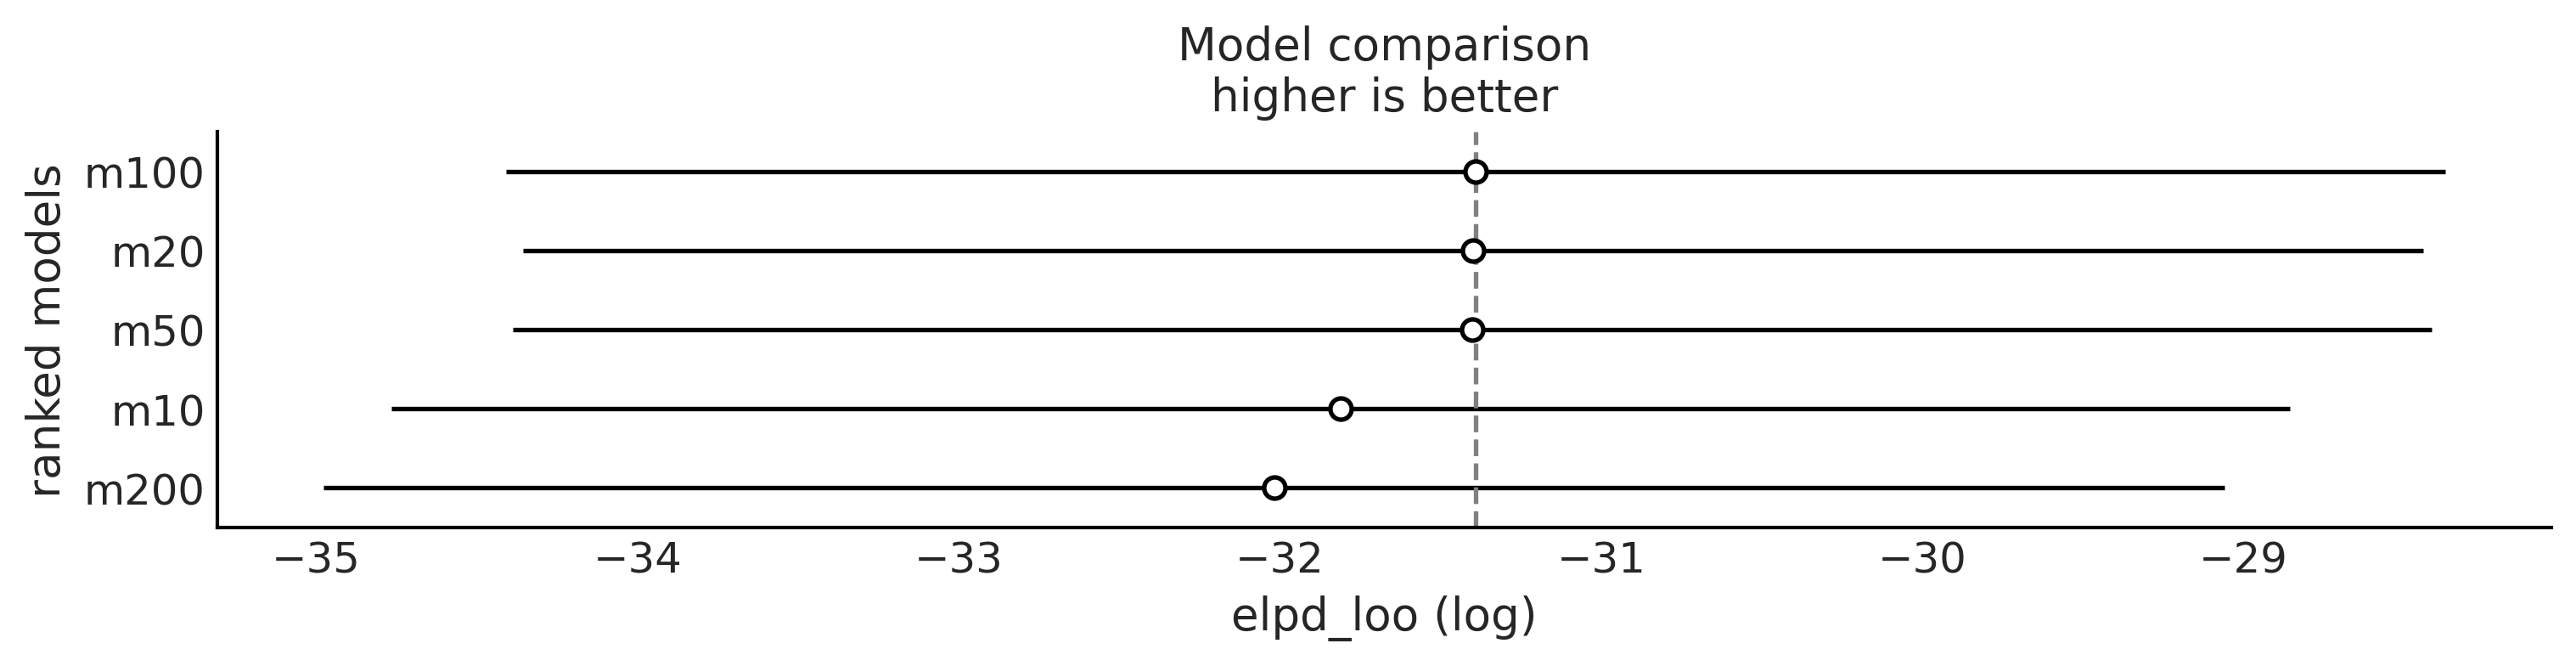

In [9]:
az.plot_compare(model_compare, plot_ic_diff=False, legend=False, figsize=(10, 2.5))
plt.savefig("loo_coal-trees.png")

## Tree extraction

In [10]:
trees_length = {}

In [13]:
for m in trees:
    tmp_list = []
    chain = m_trees[str(m)]
    for sample in chain:
        for tree in sample:
            index = max(tree.tree_structure.keys())
            tmp_list.append(pmb.tree.BaseNode(index).depth)
    trees_length[f"{m}"] = pd.Series(tmp_list)

In [14]:
q = compute_prior_probability(0.25)
p = 1 - np.array(q)
p = p / p.sum()

In [15]:
colors = ["C0", "C1", "C2", "C3", "C4"]
wd = 0.2
wd_lst = [0, wd, wd * 2, wd * 3, wd * 4]

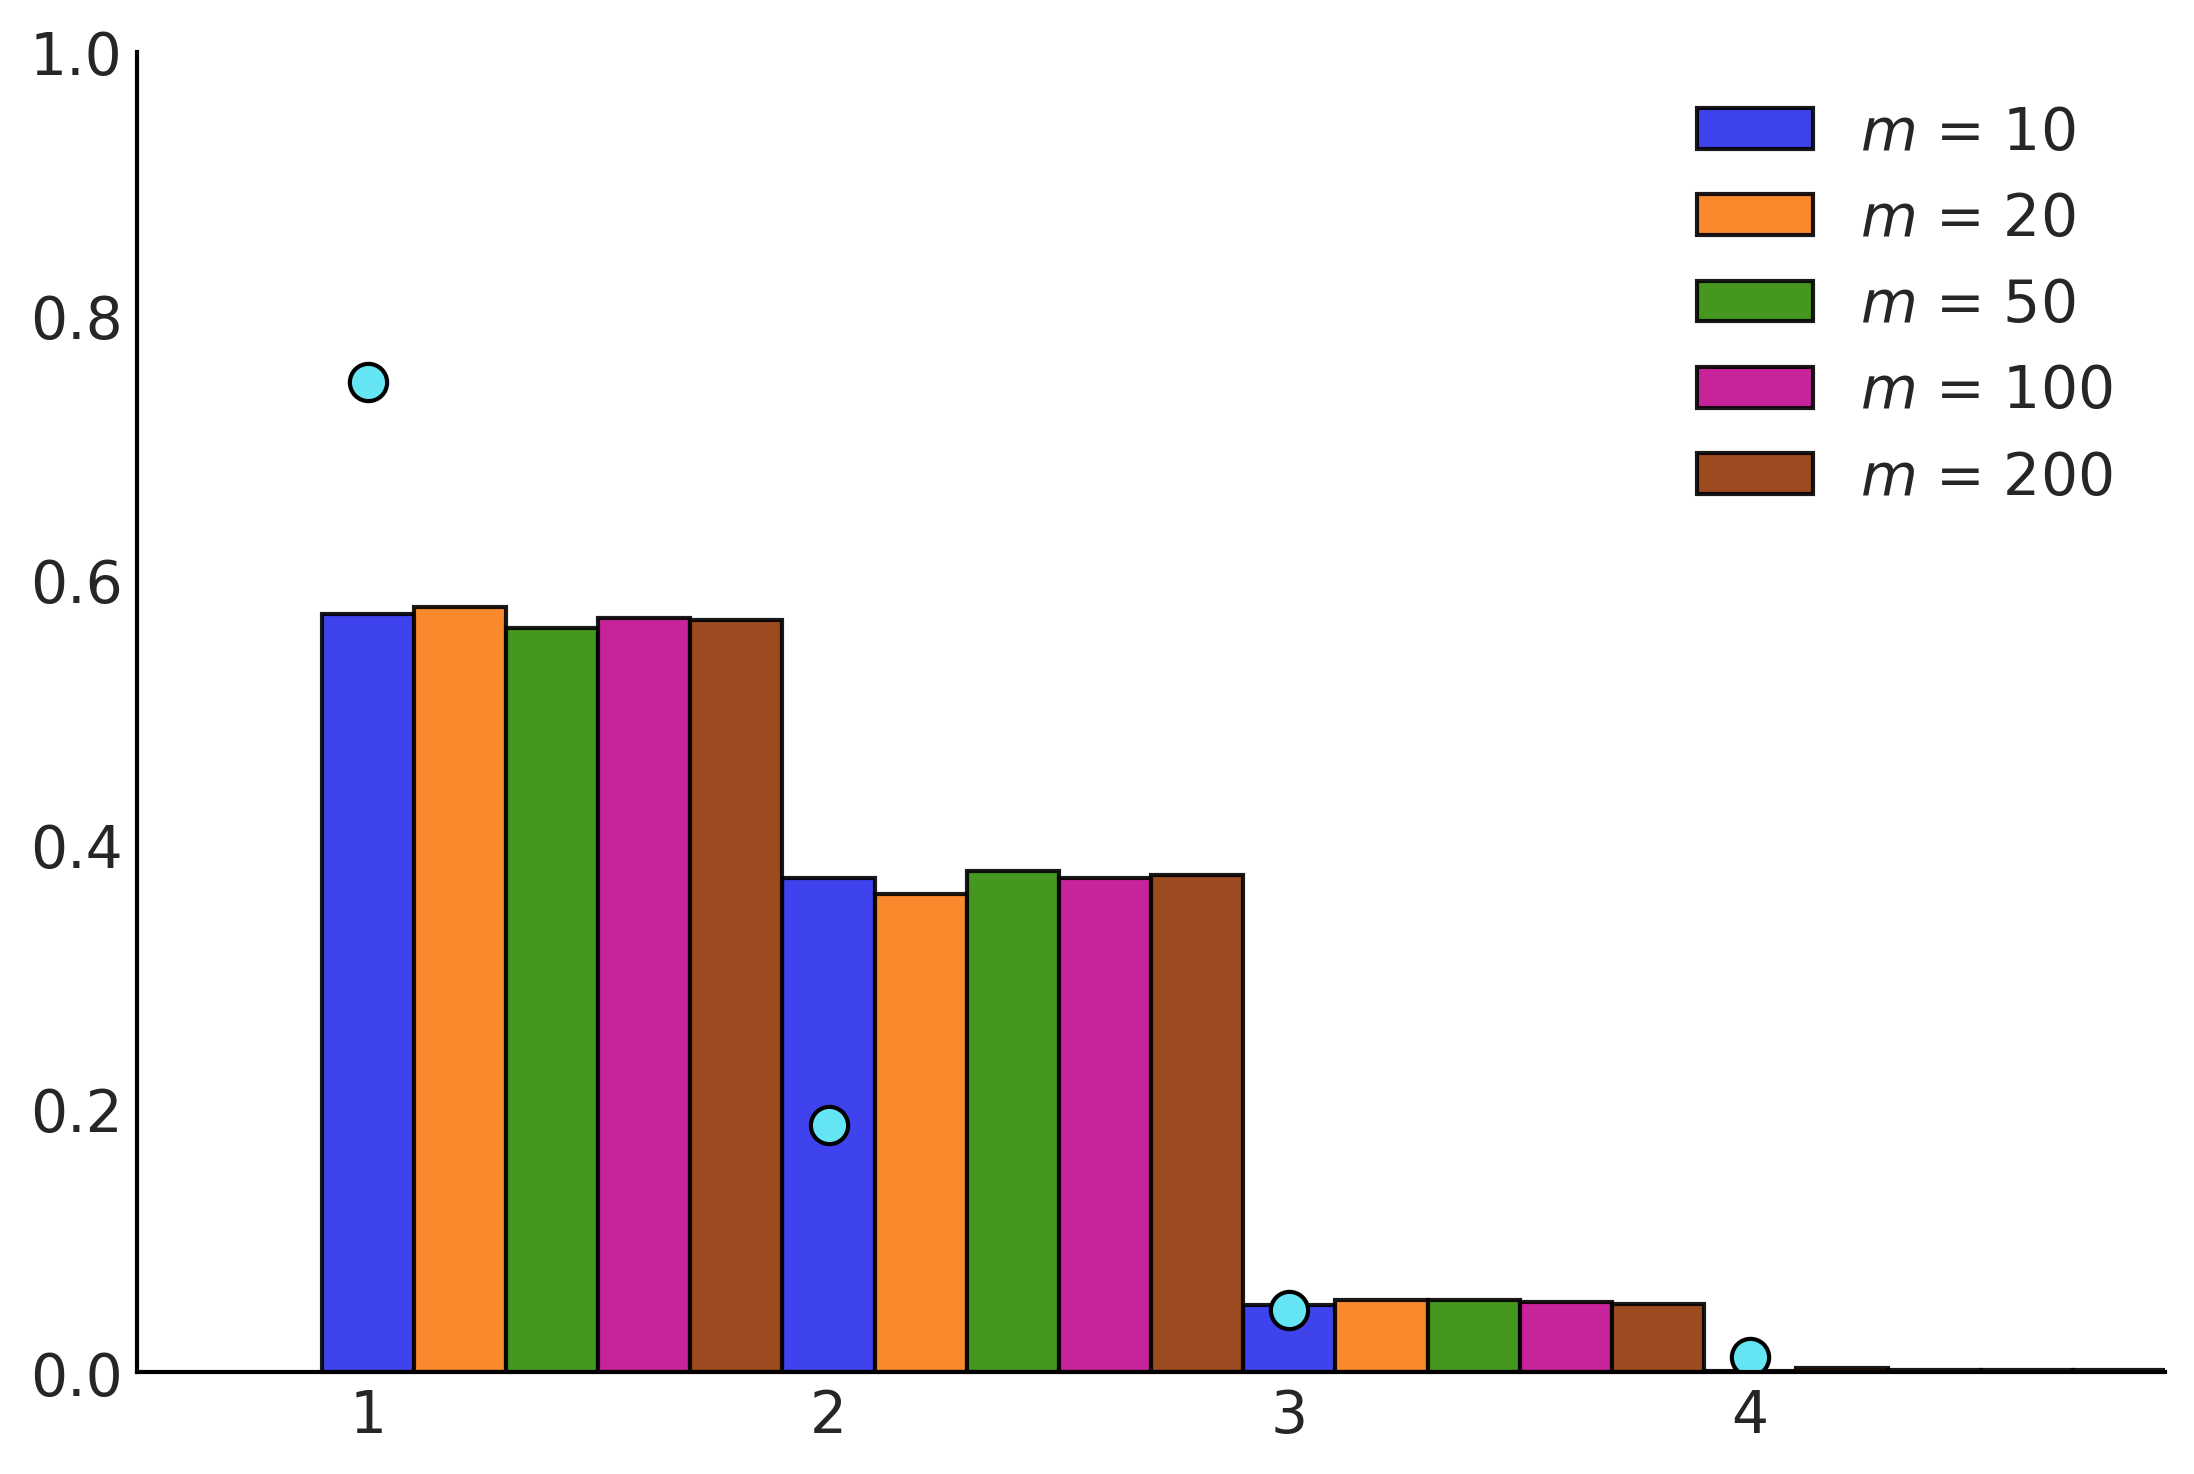

In [16]:
fig = plt.figure()
for i in range(0, len(trees)):
    # Tree Depth Frequency
    frequency = (
        trees_length[f"{trees[i]}"]
        .value_counts(normalize=True)
        .sort_index(ascending=True)
    )
    plt.bar(
        frequency.index + wd_lst[i],
        frequency.values,
        color=colors[i],
        width=wd,
        edgecolor="k",
        alpha=0.9,
        label=rf"$m$ = {trees[i]}",
    )

# Probabilities
x = np.array(range(1, len(p) + 1))
plt.scatter(x, p, facecolor="C5", edgecolor="k", marker="o", s=80, zorder=2)

major_ticks = np.arange(0, 7, 1)
plt.xticks(major_ticks)
plt.ylim(0, 1)
plt.xlim(0.5, 4.9)
plt.legend()


plt.savefig("coal_hist_m.png")